# Import libraries

In [1]:
# Import libraries
import genericIO
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

# Set the path for the executables
%env ACO_GPU_PACK=/opt/acoustic_2d/local/

# Set the path where the binaries will be written on disk
%env DATAPATH=/net/vision/scr2/gbarnier/

env: ACO_GPU_PACK=/opt/acoustic_2d/local/
env: DATAPATH=/net/vision/scr2/gbarnier/


In [2]:
%%bash
pwd

/net/server2/homes/sep/gbarnier/projects/reproducibility


# Velocity models

In [3]:
# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel/reproMarmousi-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel/reproMarmousi-initVel1.H")

# Get numpy array + hypecube info
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get axes information
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

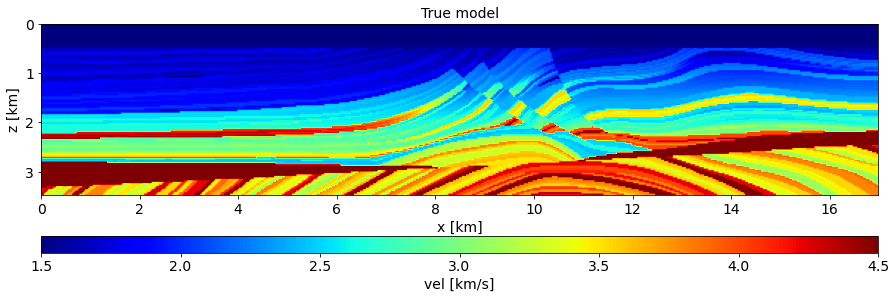

In [4]:
# Plot true velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.show()

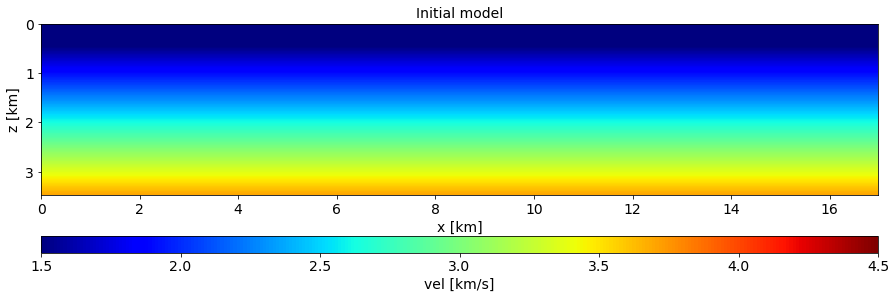

In [5]:
# Plot initial velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_init_nd.T,cmap='jet', vmin=1.5, vmax=4.5, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.show()

# Conventional data-space multi-scale FWI

## Create wavelets

In [6]:
%%bash

############ Wavelets for conventional FWI ############
# For simplicity, we generate one wavelet (and dataset per frequency band)
# 4-6 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/reproMarmousi-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=5 f4=6 type=ali wavelet=wav/reproMarmousi-wav-4-6.H

# 4-7 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/reproMarmousi-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=5.5 f4=7 type=ali wavelet=wav/reproMarmousi-wav-4-7.H

# 4-9 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/reproMarmousi-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=7 f4=9 type=ali wavelet=wav/reproMarmousi-wav-4-9.H

# 4-11 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/reproMarmousi-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=9 f4=11 type=ali wavelet=wav/reproMarmousi-wav-4-11.H

# 4-13 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/reproMarmousi-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=10 f4=13 type=ali wavelet=wav/reproMarmousi-wav-4-13.H



## Plot wavelet spectra

In [7]:
%%bash
############### Display wavelet spectra ###############
Scale < wav/reproMarmousi-wav-4-6.H | Spectra mag=dBnorm > t1.H
Scale < wav/reproMarmousi-wav-4-7.H | Spectra mag=dBnorm > t2.H
Scale < wav/reproMarmousi-wav-4-9.H | Spectra mag=dBnorm > t3.H
Scale < wav/reproMarmousi-wav-4-11.H | Spectra mag=dBnorm > t4.H
Scale < wav/reproMarmousi-wav-4-13.H | Spectra mag=dBnorm > t5.H
Cat axis=2 t1.H t2.H t3.H t4.H t5.H > temp_spec.H


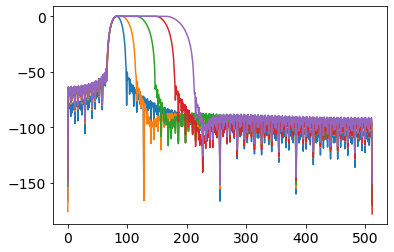

In [12]:
spectrum = genericIO.defaultIO.getVector("temp_spec.H")
# spectrum.getNdArray().shape
plt.plot(spectrum.getNdArray().T)

In [42]:
# Plot spectra
wavelet_fn_list = ['wav/reproMarmousi-wav-4-6.H','wav/reproMarmousi-wav-4-7.H']

wavelets = []
for wavelet_fn in wavelet_fn_list:
    wavelets.append(genericIO.defaultIO.getVector(wavelet_fn).getNdArray())
wavelets = np.array(wavelets)

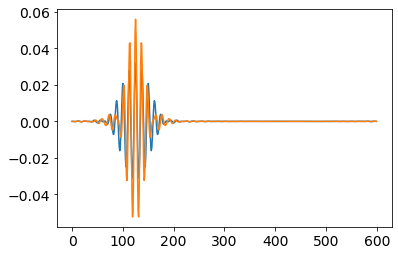

In [44]:
plt.figure()
for wavelet in wavelets:
    plt.plot(wavelet)
# wavelets.shape

## Create data

In [13]:
%%bash

# 4-6 Hz
python3.8 ${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/reproMarmousi-fwi-4-13.p vel=vel/reproMarmousi-trueVel.pad.H model=wav/reproMarmousi-wav-4-6.H data=junk.H info=0 nGpu=4

# 4-7 Hz
python3.8 ${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/reproMarmousi-fwi-4-13.p vel=vel/reproMarmousi-trueVel.pad.H model=wav/reproMarmousi-wav-4-7.H data=junk.H info=0 nGpu=4

# 4-9 Hz
python3.8 ${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/reproMarmousi-fwi-4-13.p vel=vel/reproMarmousi-trueVel.pad.H model=wav/reproMarmousi-wav-4-9.H data=junk.H info=0 nGpu=4

# 4-11 Hz
python3.8 ${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/reproMarmousi-fwi-4-13.p vel=vel/reproMarmousi-trueVel.pad.H model=wav/reproMarmousi-wav-4-11.H data=junk.H info=0 nGpu=4

# 4-13 Hz
python3.8 ${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/reproMarmousi-fwi-4-13.p vel=vel/reproMarmousi-trueVel.pad.H model=wav/reproMarmousi-wav-4-13.H data=junk.H info=0 nGpu=4

/usr/local/lib/python3.8/dist-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



## Plot data for QC

In [23]:
obs_data = genericIO.defaultIO.getVector("junk.H")
obs_data

floatVector
Axis 1: n=600	o=0.000000	d=0.016000
Axis 2: n=567	o=-0.000000	d=0.030000
Axis 3: n=140	o=-0.000000	d=0.120000

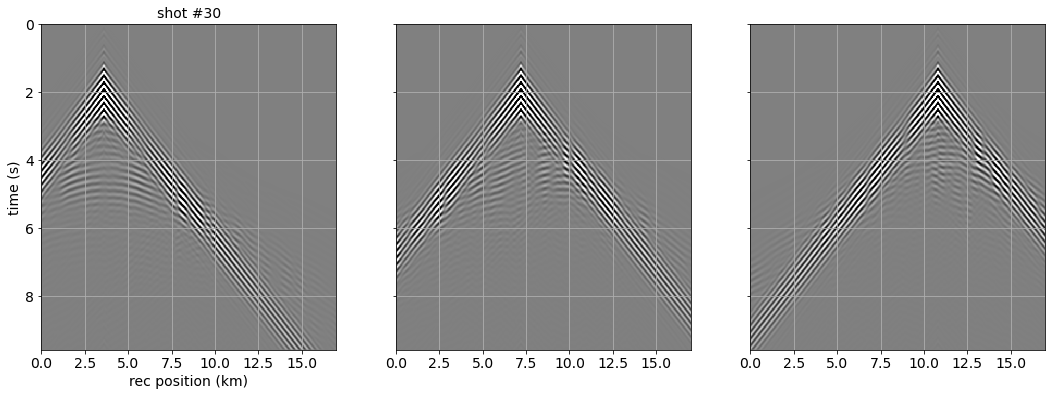

In [33]:
obs_data_np = obs_data.getNdArray()

pclip=99
clip=np.percentile(np.abs(obs_data_np),pclip)

d_rec = obs_data.getHyper().getAxis(2).d
n_rec = obs_data.getHyper().getAxis(2).n
x_axis = np.arange(n_rec) * d_rec
d_t = obs_data.getHyper().getAxis(1).d
n_t = obs_data.getHyper().getAxis(1).n
t_axis = np.arange(n_t) * d_t

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axs[0].pcolormesh(x_axis, t_axis, obs_data_np[30].T,vmin=-clip,vmax=clip)
axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_ylabel('time (s)')
axs[0].set_xlabel('rec position (km)')
axs[0].set_title('shot #30')

axs[1].pcolormesh(x_axis, t_axis, obs_data_np[60].T,vmin=-clip,vmax=clip)
axs[1].invert_yaxis()
axs[1].grid()

axs[2].pcolormesh(x_axis, t_axis, obs_data_np[90].T,vmin=-clip,vmax=clip)
axs[2].invert_yaxis()
axs[2].grid()

In [21]:
%%bash
# Change f3 value to visualize a different shot (f3=0,...,139)
!Window3d n3=1 f3=10 < dat/reproMarmousi-data-4-6.H > t1.H
!Window3d n3=1 f3=10 < dat/reproMarmousi-data-4-7.H > t2.H
!Window3d n3=1 f3=10 < dat/reproMarmousi-data-4-9.H > t3.H
!Window3d n3=1 f3=10 < dat/reproMarmousi-data-4-11.H > t4.H
!Window3d n3=1 f3=10 < dat/reproMarmousi-data-4-13.H > t5.H
Cat axis=3 t1.H t2.H t3.H t4.H t5.H | Grey grid=y gainpanel=a titles="6Hz:7Hz:9Hz:11Hz:13Hz" | Xtpen pixmaps=y &

bash: line 1: !Window3d: command not found
bash: line 2: !Window3d: command not found
bash: line 3: !Window3d: command not found
bash: line 4: !Window3d: command not found
bash: line 5: !Window3d: command not found
bash: line 6: Cat: command not found
bash: line 6: Grey: command not found
bash: line 6: Xtpen: command not found


## Conventional data-space multi-scale FWI

In [ ]:
%%bash

# 4-6 Hz
!python3.8 ${ACO_GPU_PACK}/${B}/fwiMain.py par=par/reproMarmousi-fwi-4-13.p sources=wav/reproMarmousi-wav-4-6.H vel=vel/reproMarmousi-initVel1.pad.H data=dat/reproMarmousi-data-4-6.H nIter=500 folder=reproMarmousi-fwi-4-6Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs

# 4-7 Hz
!python3.8 ${ACO_GPU_PACK}/${B}/fwiMain.py par=par/reproMarmousi-fwi-4-13.p sources=wav/reproMarmousi-wav-4-7.H vel=reproMarmousi-fwi-4-6Hz/reproMarmousi-fwi-4-6Hz_inv_mod.H data=dat/reproMarmousi-data-4-7.H nIter=500 folder=reproMarmousi-fwi-4-7Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs

# 4-9 Hz
!python3.8 ${ACO_GPU_PACK}/${B}/fwiMain.py par=par/reproMarmousi-fwi-4-13.p sources=wav/reproMarmousi-wav-4-9.H vel=reproMarmousi-fwi-4-7Hz/reproMarmousi-fwi-4-7Hz_inv_mod.H data=dat/reproMarmousi-data-4-9.H nIter=500 folder=reproMarmousi-fwi-4-9Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs

# 4-11 Hz
!python3.8 ${ACO_GPU_PACK}/${B}/fwiMain.py par=par/reproMarmousi-fwi-4-13.p sources=wav/reproMarmousi-wav-4-11.H vel=reproMarmousi-fwi-4-9Hz/reproMarmousi-fwi-4-9Hz_inv_mod.H data=dat/reproMarmousi-data-4-11.H nIter=500 folder=reproMarmousi-fwi-4-11Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs

# 4-13 Hz
!python3.8 ${ACO_GPU_PACK}/${B}/fwiMain.py par=par/reproMarmousi-fwi-4-13.p sources=wav/reproMarmousi-wav-4-13.H vel=reproMarmousi-fwi-4-11Hz/reproMarmousi-fwi-4-11Hz_inv_mod.H data=dat/reproMarmousi-data-4-13.H nIter=500 folder=reproMarmousi-fwi-4-13Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs

## Display results

In [ ]:
# Objective functions
# Inverted models

# Full waveform inversion by model extension

In [10]:
!python --version

/opt/share/Modules/init/csh: No such file or directory.
Python 3.9.7


In [45]:
import holoviews as hv